In [1]:
import time
import argparse
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data as data_utils

DATASET_DIR = "data"
TEST_AT_EPOCH_END = True

# Hyperparameters

In [2]:
class Args:
    experiment = "lenet"  # choices = ("lenet", "resnet", "vit")
    cuda = True
    seed = 0
    model_seed = 0
    num_workers = 0
    lr = 3e-3
    batch_size = 32
    epochs = 7

args = Args()

# Utils

## Models

### LeNet

In [3]:
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)  # add padding
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.t = 1

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### ResNet9

In [4]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


### ViT

In [5]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit.py

import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

from math import log2

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(patches, temperature = 10000, dtype = torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device = device), torch.arange(w, device = device), indexing = 'ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :] 
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)
        magic_const = (self.heads / 2 * (1 + log2(self.heads))) ** (1 / 3)
        qkv = self.to_qkv(x).div(magic_const).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

## Params Utils

In [38]:
@torch.no_grad()
def get_flat_params(optimizer):
    return torch.cat([p.view(-1) for group in optimizer.param_groups for p in group['params']])


@torch.no_grad()
def get_flat_grads(optimizer):
    return torch.cat([p.grad.view(-1) for group in optimizer.param_groups for p in group['params'] if p.grad is not None])


@torch.no_grad()
def get_flat_exp_avg_sq(optimizer):
    return torch.cat([optimizer.state[p]["exp_avg_sq"].view(-1) for group in optimizer.param_groups for p in group['params'] if "exp_avg_sq" in optimizer.state[p]])


@torch.no_grad()
def set_flat_params(optimizer, flat_params):
    j = 0
    for group in optimizer.param_groups:
        for p in group['params']:
            p.data.copy_(flat_params[j:j + p.numel()].reshape_as(p).data)
            j += p.numel()


@torch.no_grad()
def set_flat_grads(optimizer, flat_grads):
    j = 0
    for group in optimizer.param_groups:
        for p in group['params']:
            if p.grad is not None:
                p.grad.data.copy_(flat_grads[j:j + p.numel()].reshape_as(p).data)
                j += p.numel()


@torch.no_grad()
def set_model_flat_params(model, flat_params):
    j = 0
    for p in model.parameters():
        p.data.copy_(flat_params[j:j + p.numel()].reshape_as(p).data)
        j += p.numel()


@torch.no_grad()
def check_sparsity(model, eps=1e-8, show_results=True):
    nonzeros = sum((p.abs() > eps).sum().item() for p in model.parameters())
    total_params = sum((p.numel() for p in model.parameters()))
    sparsity = 1 - nonzeros / total_params
    if show_results:
        print(f"Sparsity = {100 * sparsity:.2f}%")
    return sparsity

## Test Utils

In [39]:
@torch.no_grad()
def test(model, loss_fn, test_loader, device, show_results=True, get_gradnorm=False):
    model.eval()

    def closure():
        test_loss = 0
        correct = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y) / len(test_loader)
            if get_gradnorm:
                loss.backward()
            test_loss += loss.item()
            # Accuracy
            pred = y_pred.max(dim=1).indices
            correct += (pred == y).sum().item()
        return test_loss, correct

    if get_gradnorm:
        closure = torch.enable_grad()(closure)
        test_loss, correct = closure()
        flat_grad = []
        for i, p in enumerate(model.parameters()):
            if p.grad is not None:
                flat_grad.append(p.grad.view(-1))
                p.grad = None
        gradnorm = torch.cat(flat_grad).pow(2).sum().sqrt().item()
    else:
        test_loss, correct = closure()
        gradnorm = 0.0

    sparsity = check_sparsity(model, show_results=False)
    acc = correct / len(test_loader.dataset)
    error = 1 - acc
    if show_results:
        print(f"\nTest set: Average loss: {test_loss:.4f}, "
              f"Accuracy: {correct}/{len(test_loader.dataset)} ({100. * acc:.0f}%), "
              f"Sparsity: {100. * sparsity:.2f}%\n")

    return test_loss, gradnorm, error, sparsity



## Train Utils

In [40]:
def train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch,
          log_interval=50, test_interval=0.25, get_gradnorm=False):
    model.train()
    data = []
    # Add test at initial point
    if epoch == 1:
        result0 = test(model, loss_fn, test_loader, device, show_results=True, get_gradnorm=get_gradnorm)
        data.append((0.,) + result0)

    # Training loop
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        def closure():
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        # Logging
        if batch_idx % log_interval == 0:
            batch_ratio = batch_idx / len(train_loader)
            sparsity = check_sparsity(model, show_results=False)
            print(f"Train Epoch: {epoch} [{batch_idx * len(x)}/{len(train_loader.dataset)} "
                  f"({100. * batch_ratio:.0f}%)]\tLoss: {loss.item():.6f},\tSparsity: {100. * sparsity:.2f}%")
        # Testing
        should_test = (batch_idx + 1) % round(test_interval * len(train_loader)) == 0
        last_epoch = batch_idx == len(train_loader) - 1
        if should_test or last_epoch:
            ep = epoch - 1 + (batch_idx + 1) / len(train_loader)
            # Show results if last batch
            result = test(model, loss_fn, test_loader, device, show_results=last_epoch, get_gradnorm=get_gradnorm)
            data.append((ep,) + result)

    return data


## Optimizer Wrappers

### DecoupledDecay Wrapper

In [31]:
class DecoupledDecay(torch.optim.Optimizer):
    def __init__(self, params, decay_type=None, decay_rate=1e-3, decay_threshold=2e-4, **kwargs):
        super().__init__(params, **kwargs)
        self.decay_type = decay_type
        self.decay_rate = decay_rate
        self.decay_threshold = decay_threshold
        self.decay = {}

    def __repr__(self):
        return "Decayed." + super().__repr__()

    @torch.no_grad()
    def step(self, closure):
        if self.decay_type is None:
            return super().step(closure)
 
        # calculate decay
        for group in self.param_groups:
            for p in group['params']:
                if self.decay_type == "l1":
                    decay = torch.sign(p).clone()
                elif self.decay_type == "hinge":
                    if "exp_avg_sq" in self.state[p]:
                        scale = self.state[p]["exp_avg_sq"].add(1e-12).pow(-0.5)
                    else:
                        scale = torch.ones_like(p)
                    if self.decay_threshold >= 0:
                        decay_region = p.abs() > self.decay_threshold * scale
                    else:
                        decay_region = p.abs() < -self.decay_threshold * scale
                    decay = torch.zeros_like(p)
                    decay[decay_region] = torch.sign(p[decay_region]).clone()
                else:
                    decay = p.clone()
                self.decay[p] = group['lr'] * self.decay_rate * decay
        # step
        loss = super().step(closure)
        # apply decoupled decay
        for group in self.param_groups:
            for p in group['params']:
                p.sub_(self.decay[p])

        return loss

### Masked Optimizer Wrapper

In [62]:
class MaskedOptimizer(torch.optim.Optimizer):
    def __init__(self, *args, prune_threshold=1e-8, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask = {}
        self.prune_threshold = prune_threshold
        self.use_masked_closure = False  # TODO

    def __repr__(self):
        return "Masked." + super().__repr__()

    def _parameters(self):
        for group in self.param_groups:
            for param in group['params']:
                yield param

    @torch.no_grad()
    def update_mask(self):
        for p in self._parameters():
            if p in self.mask:
                self.mask[p] &= p != 0.
            else:
                self.mask[p] = p != 0.

    @torch.no_grad()
    def mask_params(self):
        for p in self._parameters():
            if p in self.mask:
                p.mul_(self.mask[p])
                if "exp_avg" in self.state[p]:
                    self.state[p]["exp_avg"].mul_(self.mask[p])

    @torch.no_grad()
    def mask_grads(self):
        for p in self._parameters():
            if p in self.mask[p] and p.grad is not None:
                p.grad.mul_(self.mask[p])

    @torch.no_grad()
    def prune_smallest(self, sparsity=0.9):
        flat_params = get_flat_params(self)
        sparse_elems = max(1, round((1 - sparsity) * flat_params.numel()))
        threshold = torch.topk(flat_params.abs().cpu(), k=sparse_elems).values[-1]
        flat_params[flat_params.abs() < threshold] = 0.
        set_flat_params(self, flat_params)
        self.update_mask()

    @torch.no_grad()
    def prune_smaller_than(self, threshold=None):
        if threshold is None:
            # threshold = self.prune_threshold  # XXX
            threshold = self.prune_threshold * (get_flat_exp_avg_sq(self).sqrt() + 1e-8)
        flat_params = get_flat_params(self)
        flat_params[flat_params.abs() < threshold] = 0.
        set_flat_params(self, flat_params)
        self.update_mask()

    @torch.no_grad()
    def masked_closure(self, closure):
        closure = torch.enable_grad()(closure)

        def closure_then_mask_grads():
            closure()
            self.mask_grads()

        return closure_then_mask_grads

    def step(self, closure):
        if self.use_masked_closure:
            closure = self.masked_closure(closure)
        loss = super().step(closure)  # assuming first-order step
        self.prune_smaller_than()
        self.mask_params()
        return loss


@torch.no_grad()
def prune_smallest(optimizer, sparsity=0.9):
    flat_params = get_flat_params(optimizer)
    sparse_elems = max(1, round((1 - sparsity) * flat_params.numel()))
    threshold = torch.topk(flat_params.abs().cpu(), k=sparse_elems).values[-1]
    flat_params[flat_params.abs() < threshold] = 0.
    set_flat_params(optimizer, flat_params)
    optimizer.update_mask()


@torch.no_grad()
def g2_prune_smaller_than(optimizer, threshold):
    flat_params = get_flat_params(optimizer)
    flat_exp_avg_sq = torch.cat([optimizer.state[p]["exp_avg_sq"].view(-1)
                                 for group in optimizer.param_groups for p in group['params'] if "exp_avg_sq" in optimizer.state[p]])
    flat_params[flat_exp_avg_sq.abs() < threshold] = 0.
    set_flat_params(optimizer, flat_params)
    return flat_params


@torch.no_grad()
def g2_prune_bigger_than(optimizer, threshold):
    flat_params = get_flat_params(optimizer)
    flat_exp_avg_sq = torch.cat([optimizer.state[p]["exp_avg_sq"].view(-1)
                                 for group in optimizer.param_groups for p in group['params'] if "exp_avg_sq" in optimizer.state[p]])
    flat_params[flat_exp_avg_sq.abs() > threshold] = 0.
    set_flat_params(optimizer, flat_params)
    return flat_params

### SAM Wrapper

In [63]:
class SAMBase(torch.optim.Optimizer):
    def __init__(self, params, rho=0.05, scaled_max='gradnorm', **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        self.adam_initialized = False
        super().__init__(params, **kwargs)
        for group in self.param_groups:
            group.setdefault("rho", rho)
            group.setdefault("scaled_max", scaled_max)

    def _init_adam(self, closure):
        for group in self.param_groups:
            for p in group["params"]:
                p.grad = torch.zeros_like(p)
        super().step(closure)  # dummy step
        self.adam_initialized = True

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        if not self.adam_initialized:
            self._init_adam(closure)

        closure = torch.enable_grad()(closure)

        loss = closure()
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                # how to scale max step
                if group["scaled_max"] == "none":
                    denom = torch.ones(1)
                    g = p.grad
                elif group["scaled_max"] == "adam" and "exp_avg_sq" in self.state[p]:
                    bias_correction1 = 1 - group["betas"][0] ** self.state[p]["step"]
                    bias_correction2 = 1 - group["betas"][1] ** self.state[p]["step"]
                    denom = self.state[p]["exp_avg_sq"].div(bias_correction2).sqrt().add(1e-8)
                    g = self.state[p]["exp_avg"].div(bias_correction1)
                else:
                    denom = (grad_norm + 1e-8).to(p)
                    g = p.grad
                # step
                self.state[p]["old_p"] = p.data.clone()
                # p.add_(g.div(denom), alpha=group["lr"] * group["rho"])
                p.addcdiv_(g, denom, value=group["lr"] * group["rho"])
                p.grad = None

        closure()  # get grad at w+e
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data.copy_(self.state[p]["old_p"])  # set params back to w

        super().step()  # "sharpness-aware" update

        return loss

    def _grad_norm(self):
        # put everything on the same device, in case of model parallelism
        shared_device = self.param_groups[0]["params"][0].device
        gradnorm = torch.stack([
            p.grad.pow(2).sum().to(shared_device)
            for group in self.param_groups for p in group["params"] if p.grad is not None
        ]).sum().sqrt()
        return gradnorm

    def __repr__(self):
        return "SharpnessAware." + super().__repr__()


class SAM(SAMBase, torch.optim.SGD):
    pass

class SADAM(SAMBase, torch.optim.Adam):
    pass

## Experiment Utils

In [64]:
def make_masked_and_decayed(Optimizer):
    class MaskedDecayedOptimizer(MaskedOptimizer, DecoupledDecay, Optimizer):
        def __repr__(self):
            return Optimizer.__name__ + "." + super().__repr__()
        pass
    return MaskedDecayedOptimizer


def init_device(cuda):
    use_cuda = torch.cuda.is_available() and cuda
    use_mps = torch.backends.mps.is_available() and cuda
    device = torch.device("cuda" if use_cuda else ("mps" if use_mps else "cpu"))
    if use_cuda:
        print(f"Using CUDA")
    if use_mps:
        print(f"Using MPS")


def init_seed(seed):
    if seed is not None:
        print(f"Setting random seed to {seed}.")
        np.random.seed(seed)
        torch.manual_seed(seed)


def init_model(experiment="lenet"):
    experiment = experiment.lower()
    if experiment == "lenet":
        model = LeNet5()

    elif experiment == "resnet":
        model = ResNet9()

    elif experiment == "vit":
        model = SimpleViT(image_size=32,
                    patch_size=8,
                    num_classes=10,  # for cifar 10
                    dim=128,
                    depth=12,
                    heads=8,
                    mlp_dim=64)
    
    else:
        raise NotImplementedError(f"experiment '{experiment}' not implemented.")

    return model


@ torch.no_grad()
def count_params(model):
    return sum(p.numel() for p in model.parameters())


def load_dataset(experiment="lenet"):
    experiment = experiment.lower()
    if experiment == "lenet":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_dataset = datasets.MNIST(DATASET_DIR, train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(DATASET_DIR, train=False, transform=transform)

    elif experiment in ("resnet", "vit"):
        image_size = 32
        transform = transforms.Compose([
            transforms.Grayscale(3),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
        train_dataset = datasets.MNIST(DATASET_DIR, train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(DATASET_DIR, train=False, transform=transform)
        # cifar_mean = (0.4914, 0.4822, 0.4465)
        # cifar_std = (0.2023, 0.1994, 0.2010)
        # train_transform = transforms.Compose([
        #     transforms.RandomCrop(image_size, padding=4),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.ToTensor(),
        #     transforms.Normalize(cifar_mean, cifar_std)
        # ])
        # test_transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(cifar10_mean, cifar10_std)
        # ])
        # train_dataset = datasets.CIFAR10(DATASET_DIR, train=True, download=True, transform=train_transform)
        # test_dataset = datasets.CIFAR10(DATASET_DIR, train=False, transform=test_transform)

    else:
        raise NotImplementedError(f"experiment '{experiment}' not implemented.")


    return train_dataset, test_dataset


def init_experiment(args, Optimizer=torch.optim.SGD, **optim_args):
    device = init_device(args.cuda)
    
    # All runs start are init based on the model seed
    print(f"Initializing model with random seed {args.model_seed}.")
    init_seed(args.model_seed)
    model = init_model(args.experiment).to(device)

    # Load dataset and initialize dataloader
    init_seed(args.seed)
    train_dataset, test_dataset = load_dataset(args.experiment)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                                shuffle=True, num_workers=args.num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                                shuffle=False, num_workers=args.num_workers)

    # Loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    MaskedDecayedOptimizer = make_masked_and_decayed(Optimizer)
    optimizer = MaskedDecayedOptimizer(model.parameters(), **optim_args)

    print(f"Model has {count_params(model)} parameters")

    return model, optimizer, loss_fn, train_loader, test_loader, device



### Test

In [17]:
# testing inits
args = Args()
init_experiment(args, Optimizer=torch.optim.SGD, lr=args.lr)
init_experiment(args, Optimizer=torch.optim.SGD, lr=args.lr, momentum=0.9, decay_type="l2")
init_experiment(args, Optimizer=torch.optim.Adam, lr=args.lr, betas=(0.9, 0.999))
init_experiment(args, Optimizer=SAM, lr=args.lr, momentum=0.9, rho=args.lr/2)
init_experiment(args, Optimizer=SADAM, lr=args.lr, betas=(0.9, 0.999), rho=args.lr/2)

Using MPS
Initializing model with random seed 0.
Setting random seed to 0.
Setting random seed to 0.
Model has 61706 parameters
Using MPS
Initializing model with random seed 0.
Setting random seed to 0.
Setting random seed to 0.
Model has 61706 parameters
Using MPS
Initializing model with random seed 0.
Setting random seed to 0.
Setting random seed to 0.
Model has 61706 parameters
Using MPS
Initializing model with random seed 0.
Setting random seed to 0.
Setting random seed to 0.
Model has 61706 parameters
Using MPS
Initializing model with random seed 0.
Setting random seed to 0.
Setting random seed to 0.
Model has 61706 parameters


(LeNet5(
   (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=400, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=10, bias=True)
 ),
 SADAM.Masked.Decayed.SharpnessAware.MaskedDecayedOptimizer (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.003
     maximize: False
     rho: 0.0015
     scaled_max: gradnorm
     weight_decay: 0
 ),
 CrossEntropyLoss(),
 None)

# Experiments 1

## Does Sharpness Aware Minimization help find sparser solutions and better lottery tickets?

In [ ]:
# Train
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=torch.optim.SGD, lr=args.lr, momentum=0.9, decay_type="l1")

data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results
    # prune
    check_sparsity(model)
    optimizer.prune_smallest(sparsity=1 - 0.5**epoch)
    check_sparsity(model)
    test(model, loss_fn, test_loader, device)
    print()

In [ ]:
# Train
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=SAM, lr=args.lr, momentum=0.9, rho=args.lr/2, decay_type="l1")

data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results
    # prune
    check_sparsity(model)
    optimizer.prune_smallest(sparsity=1 - 0.5**epoch)
    check_sparsity(model)
    test(model, loss_fn, test_loader, device)
    print()

## Test AdamW vs. DecayedAdam

In [ ]:
# Train
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=torch.optim.Adam, lr=args.lr, decay_type='l2', decay_rate=1e-2)
data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results

In [ ]:
# Train
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=torch.optim.AdamW, lr=args.lr, weight_decay=1e-2)
data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results

In [ ]:
# Train
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=torch.optim.Adam, lr=args.lr)
data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results

In [ ]:
# Train
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=torch.optim.Adam, lr=args.lr, decay_type='l1', decay_rate=1e-2)
data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results
    check_sparsity(model)

## Sharpness-Aware Adam with decoupled L1 decay

In [ ]:
# Train
args.lr = 1e-2
model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(
    args, Optimizer=SADAM, lr=args.lr, rho=0.005, decay_type='l1', decay_rate=1e-3, scaled_max="adam")
sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
data = []
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    sched.step()
    data += results

In [ ]:
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    sched.step()
    data += results

In [ ]:
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    sched.step()
    data += results

In [ ]:
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    sched.step()
    data += results

In [ ]:
for epoch in range(1, args.epochs + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    sched.step()
    data += results

# Experiments 2

In [65]:
rho = 0.1  # relative to lr
decay_rate = 0.1  # relative to lr
prune_threshold = 0.1  # relative to exp_avg_sq
decay_type = 'l1'
decay_threshold = 1. * prune_threshold  # XXX
optim_args = dict(lr=args.lr, rho=rho, scaled_max="adam",
                  decay_type=decay_type, decay_rate=decay_rate,
                  decay_threshold=decay_threshold, prune_threshold=prune_threshold)

model, optimizer, loss_fn, train_loader, test_loader, device = init_experiment(args, Optimizer=SADAM, **optim_args)

Using MPS
Initializing model with random seed 0.
Setting random seed to 0.
Setting random seed to 0.
Model has 61706 parameters


In [66]:
model_state_dict0 = deepcopy(model.state_dict())
optimizer_state_dict0 = deepcopy(optimizer.state_dict())

In [67]:
data = []
model.load_state_dict(model_state_dict0)
optimizer.load_state_dict(optimizer_state_dict0)

In [68]:
%%time
# for epoch in range(1, args.epochs + 1):
for epoch in range(1, 1 + 1):
    results = train(model, optimizer, loss_fn, train_loader, test_loader, device, epoch)
    data += results


Test set: Average loss: 2.3040, Accuracy: 1009/10000 (10%), Sparsity: 0.00%

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.259088,	Sparsity: 0.00%
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.908619,	Sparsity: 6.75%
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.558510,	Sparsity: 18.24%
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.214079,	Sparsity: 26.12%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.189447,	Sparsity: 32.02%
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.244747,	Sparsity: 37.84%
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.270924,	Sparsity: 42.97%
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.071859,	Sparsity: 47.22%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.117239,	Sparsity: 51.55%
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.185284,	Sparsity: 55.24%
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.091120,	Sparsity: 58.99%
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.148549,	Sparsity: 62.94%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.050124,	Sparsity: 66.71%
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.200948,	Spa

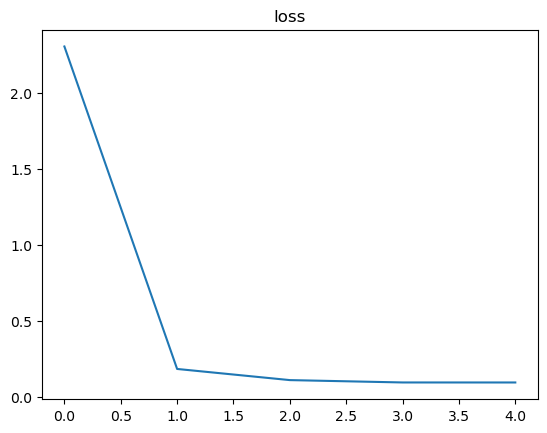

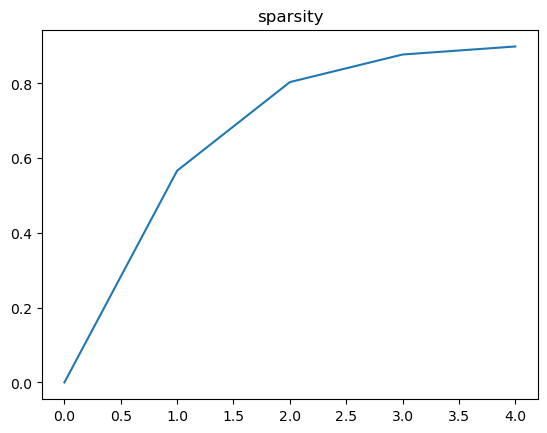

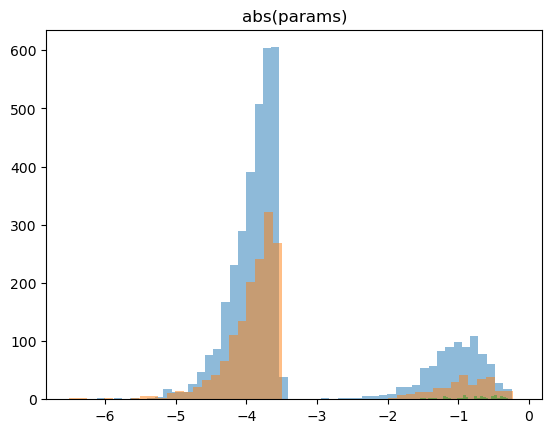

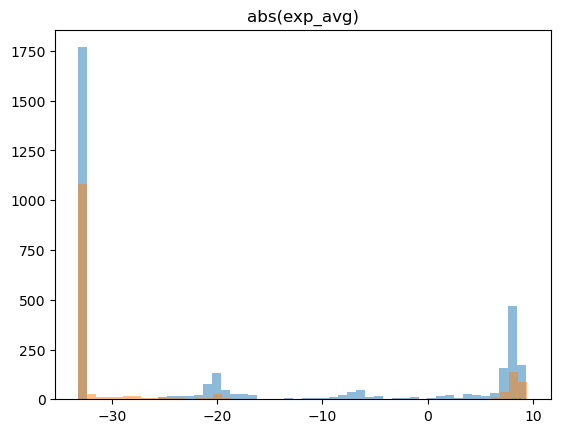

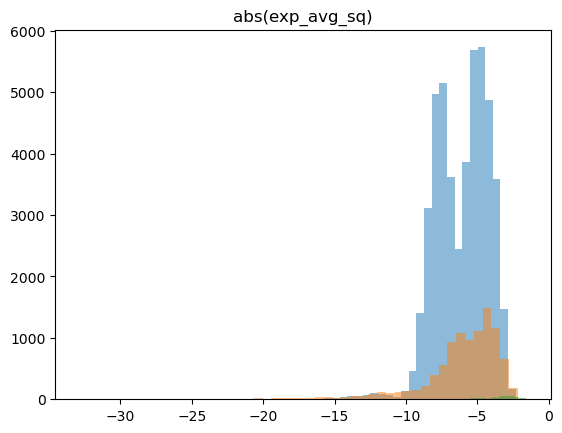

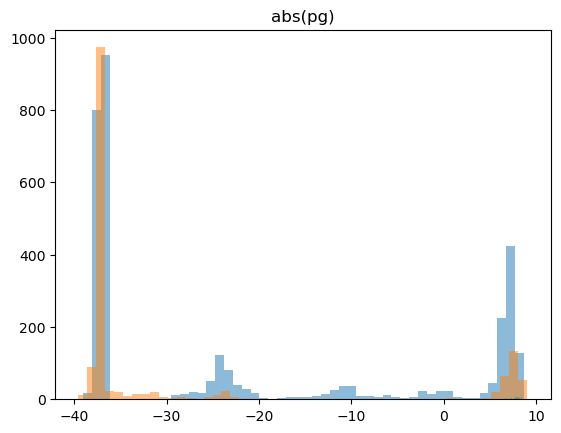

In [95]:
@torch.no_grad()
def plot_stats(optimizer, data=None):
    p1 = torch.cat([p.view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g1 = torch.cat([optimizer.state[p]['exp_avg'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g2 = torch.cat([optimizer.state[p]['exp_avg_sq'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    if data is not None:
        plt.figure()
        plt.plot(np.array(data)[:,1])
        plt.title("loss")
        plt.figure()
        plt.plot(np.array(data)[:,4])
        plt.title("sparsity")
    plt.figure()
    plt.hist(p1[p1 > 0].log10(), bins=50)
    plt.title("abs(params)")
    plt.figure()
    plt.hist(g1[g1 > 0].log10(), bins=50)
    plt.title("abs(exp_avg)")
    plt.figure()
    plt.hist(g2[g2 > 0].log10(), bins=50)
    plt.title("abs(exp_avg_sq)")
    return p1, g1, g2

@torch.no_grad()
def plot_stats2(optimizer, data=None, num_dims=2):
    p1 = torch.cat([p.view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g1 = torch.cat([optimizer.state[p]['exp_avg'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g2 = torch.cat([optimizer.state[p]['exp_avg_sq'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    if data is not None:
        plt.figure()
        plt.plot(np.array(data)[:,1])
        plt.title("loss")
        plt.figure()
        plt.plot(np.array(data)[:,4])
        plt.title("sparsity")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                p1 = p.cpu().abs()
                plt.hist(p1[p1 > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(params)")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                g1 = optimizer.state[p]["exp_avg"].cpu().abs()
                plt.hist(g1[g1 > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(exp_avg)")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                g2 = optimizer.state[p]["exp_avg_sq"].cpu().abs()
                plt.hist(g2[g2 > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(exp_avg_sq)")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                pg = (p * optimizer.state[p]["exp_avg"]).cpu().abs()
                plt.hist(pg[pg > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(pg)")
    return p1, g1, g2


_ = plot_stats2(optimizer, data)

## Checkpoint

In [ ]:
@torch.no_grad()
def set_model_flat_params(model, flat_params):
    j = 0
    for p in model.parameters():
        p.data.copy_(flat_params[j:j + p.numel()].reshape_as(p).data)
        j += p.numel()

@torch.no_grad()
def get_flat_grads(optimizer):
    return torch.cat([p.grad.view(-1) for group in optimizer.param_groups for p in group['params'] if p.grad is not None])

@torch.no_grad()
def g2_prune_smaller_than(optimizer, threshold=None):
    # if threshold is None:
    #     threshold = self.prune_threshold
    flat_params = get_flat_params(optimizer)
    flat_exp_avg_sq = torch.cat([optimizer.state[p]["exp_avg_sq"].view(-1)
                                 for group in optimizer.param_groups for p in group['params'] if "exp_avg_sq" in optimizer.state[p]])
    flat_params[flat_exp_avg_sq.abs() < threshold] = 0.
    set_flat_params(optimizer, flat_params)
    return flat_params
    # self.update_mask()

@torch.no_grad()
def g2_prune_bigger_than(optimizer, threshold=None):
    # if threshold is None:
    #     threshold = self.prune_threshold
    flat_params = get_flat_params(optimizer)
    flat_exp_avg_sq = torch.cat([optimizer.state[p]["exp_avg_sq"].view(-1)
                                 for group in optimizer.param_groups for p in group['params'] if "exp_avg_sq" in optimizer.state[p]])
    flat_params[flat_exp_avg_sq.abs() > threshold] = 0.
    set_flat_params(optimizer, flat_params)
    return flat_params
    # self.update_mask()

@torch.no_grad()
def plot_stats(optimizer, data=None):
    p1 = torch.cat([p.view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g1 = torch.cat([optimizer.state[p]['exp_avg'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g2 = torch.cat([optimizer.state[p]['exp_avg_sq'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    if data is not None:
        plt.figure()
        plt.plot(np.array(data)[:,4])
        plt.title("sparsity")
    plt.figure()
    plt.hist(p1[p1 > 0].log10(), bins=50)
    plt.title("abs(params)")
    plt.figure()
    plt.hist(g1[g1 > 0].log10(), bins=50)
    plt.title("abs(exp_avg)")
    plt.figure()
    plt.hist(g2[g2 > 0].log10(), bins=50)
    plt.title("abs(exp_avg_sq)")
    return p1, g1, g2

@torch.no_grad()
def plot_stats2(optimizer, data=None, num_dims=2):
    p1 = torch.cat([p.view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g1 = torch.cat([optimizer.state[p]['exp_avg'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    g2 = torch.cat([optimizer.state[p]['exp_avg_sq'].view(-1) for group in optimizer.param_groups for p in group['params']]).cpu().abs()
    if data is not None:
        plt.figure()
        plt.plot(np.array(data)[:,4])
        plt.title("sparsity")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                p1 = p.cpu().abs()
                plt.hist(p1[p1 > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(params)")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                g1 = optimizer.state[p]["exp_avg"].cpu().abs()
                plt.hist(g1[g1 > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(exp_avg)")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                g2 = optimizer.state[p]["exp_avg_sq"].cpu().abs()
                plt.hist(g2[g2 > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(exp_avg_sq)")
    plt.figure()
    for group in optimizer.param_groups:
        for p in group['params']:
            if len(p.shape) == num_dims:
                pg = (p * optimizer.state[p]["exp_avg"]).cpu().abs()
                plt.hist(pg[pg > 0].log10(), bins=50, alpha=0.5)
    plt.title("abs(pg)")
    return p1, g1, g2

